this notebook creates two maps that show the Hunza watershed with ESRI imagery
- first map overlays the algorithm calculated melt onset dates (MOD) for SIR pixels
- second map overlays the algorithm calculated melt onset dates (MOD) for GRD pixels

the pixel overlays are simply a scatter plot with rectangular markers and are not using EASE-grid projection

## Load in all the modules needed

In [1]:
%pylab notebook
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
from cetbtools.ease2conv import Ease2Transform
from mpl_toolkits.basemap import Basemap
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
# navigate to where scripts are saved
% cd /home/shared/Data3/cetb/jupyter_notebooks/scripts/

/mnt/data3/cetb/jupyter_notebooks/scripts


In [3]:
# load the custom functions
from CETB_read_functions import read_Tb
from CETB_read_functions import coords
from CETB_read_functions import calc_DAV
from CETB_read_functions import find_UIB_cube_offset
from CETB_read_functions import find_GLaIL_cube_offset
from CETB_read_functions import grid_locations_of_UIB
from CETB_read_functions import grid_locations_of_GLaIL
from CETB_algorithms import DAV_MOD
from CETB_analysis import MOD_array
from CETB_analysis import MOD_array_year

## Specify inputs

In [4]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='GLaIL'  #make this the same syntax as cubefilenames and sub-directory
sat_GRD='F18'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sat_SIR= 'F18'
sensor_GRD='SSMIS'  #'AMSRE', 'SSMI', etc.
sensor_SIR='SSMIS'
channel_GRD='37V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
channel_SIR='37V'
alg_GRD='GRD'   #SIR or GRD
alg_SIR='SIR'

if sensor_GRD=='SSMIS':
    provider='CSU' 
    version='v1.*' #note need to check for different sensors v1.2, 1.3, 1.4
elif sensor_GRD=='AMSRE':
    provider='RSS'
    version='v1.3'

# either change to the directory where the data is or specify it
datadir_GRD = '/home/mij216/Desktop/data3/cetb/cubes/'+sat_GRD+'_'+sensor_GRD+'/'+region+'/' 
datadir_SIR = '/home/mij216/Desktop/data3/cetb/cubes/'+sat_SIR+'_'+sensor_SIR+'/'+region+'/' 

# prefix filepath
prefix_GRD='CETB.cubefile.'+region+'.'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'-'+provider+'-'+version
prefix_SIR='CETB.cubefile.'+region+'.'+sat_SIR+'_'+sensor_SIR+'-'+channel_SIR+'-'+alg_SIR+'-'+provider+'-'+version

# years for each sensor
if sat_GRD=='F13' or sat_SIR=='F13':
    Years = [2002,2003,2004,2005,2006,2007,2008,2009]
elif sat_GRD=='F14' or sat_SIR=='F14':
    Years=[2002,2003,2004,2005,2006,2007,2008]
elif sat_GRD=='F15' or sat_SIR=='F15':
    Years=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011]
elif sat_GRD=='F18' or sat_SIR=='F18':
    Years=[2016,2017,2018,2019]
elif sat_GRD=='AQUA' or sat_SIR=='AQUA':
    Years=[2003,2004,2005,2006,2007,2008,2009,2010,2011]

#Enter a site name for titles of plots
Site='Vatnajokull, Iceland'

In [5]:
# SPECIFY latitude and longitude in decimal degrees, need to choose lat/lon corners so that we will load
# in a rectangle of pixels within the corners of these coordinates
lat_start=63.75  #35.9
lat_end=64.88    #37.1
lon_start=-20 #-20 includes katla -18.5vatna    #74
lon_end=-15    #76

In [6]:
# get cube offset for finding row/col
# function is region specific
find_GLaIL_cube_offset(cubeType=None, verbose=False)

(2904.000000001132, 2063.999999962362)

In [7]:
# get the GRD pixel IDs for the lat/lon rectangle chosen
rows_cols_GRD=coords(datadir_GRD, prefix_GRD, lat_start, lat_end, lon_start, lon_end)
rows_cols_GRD

(102, 108, 63, 72)

In [8]:
# row and col numbers of all the SIR pixels contained by the GRD pixels
rows_cols_env=[rows_cols_GRD[0]*8,rows_cols_GRD[1]*8, rows_cols_GRD[2]*8, rows_cols_GRD[3]*8]
rows_cols_env

[816, 864, 504, 576]

In [9]:
# load in SIR TB data
data_SIR=read_Tb(datadir_SIR, prefix_SIR, Years,rows_cols_env[0],rows_cols_env[1],rows_cols_env[2],rows_cols_env[3])
CETB_SIR=data_SIR[0]   # 3-D Tb time-series array of TB
cal_date=data_SIR[1]    # 1-D array of dates, these will get passed to later functions
cal_year=data_SIR[2]    # 1-D array of years
cal_month=data_SIR[3]   # 1-D array of months

# load GRD Tb data
data_GRD=read_Tb(datadir_GRD, prefix_GRD, Years,rows_cols_GRD[0],rows_cols_GRD[1],rows_cols_GRD[2],rows_cols_GRD[3])
CETB_GRD=data_GRD[0]

In [10]:
# calculate DAV for the Tb data that was imported
DAV_SIR=calc_DAV(CETB_SIR)
DAV_GRD=calc_DAV(CETB_GRD)

## get the latitudes and longitudes of each pixel for plotting

In [11]:
#Get lat/lon of each pixel in the subset of 64
# these get used for plotting over basemap
filename=datadir_SIR+prefix_SIR+'.'+str(2019)+'.TB.nc'	
vlist=glob.glob(filename)
data=Dataset(vlist[-1], "r", format="NETCDF4")

lat=data.variables['latitude'] 
lat=lat[:]
lon=data.variables['longitude']
lon=lon[:]
lat_lon=np.dstack((lat,lon))

coordinates=lat_lon[rows_cols_env[0]:rows_cols_env[1],rows_cols_env[2]:rows_cols_env[3]]

coordinates=coordinates.reshape(((rows_cols_env[1]-rows_cols_env[0])*(rows_cols_env[3]-rows_cols_env[2])),2)
pixel_lats=coordinates[:,0]
pixel_lons=coordinates[:,1]

pixel_lats

array([64.70053823, 64.71050704, 64.72044743, ..., 64.02015022,
       64.0277183 , 64.03525714])

In [13]:
#Get lat/lon for GRD pixels
# similar to SIR above
filename=datadir_GRD+prefix_GRD+'.'+str(2019)+'.TB.nc'	
vlist=glob.glob(filename)
data=Dataset(vlist[-1], "r", format="NETCDF4")

lat=data.variables['latitude'] 
lat=lat[:]
lon=data.variables['longitude']
lon=lon[:]
lat_lon=np.dstack((lat,lon))

coordinates=lat_lon[rows_cols_GRD[0]:rows_cols_GRD[1],rows_cols_GRD[2]:rows_cols_GRD[3]]

coordinates=coordinates.reshape(((rows_cols_GRD[1]-rows_cols_GRD[0])*(rows_cols_GRD[3]-rows_cols_GRD[2])),2)
pixel_lats_GRD=coordinates[:,0]
pixel_lons_GRD=coordinates[:,1]

pixel_lats_GRD

array([64.64087384, 64.7187557 , 64.79480296, 64.86900027, 64.94133249,
       65.01178467, 65.08034208, 65.14699023, 65.21171486, 64.42478943,
       64.50205811, 64.57750288, 64.65110875, 64.72286092, 64.79274482,
       64.86074606, 64.92685051, 64.99104426, 64.20837134, 64.28503668,
       64.3598887 , 64.43291276, 64.50409444, 64.57341947, 64.64087384,
       64.70644375, 64.77011563, 63.99162408, 64.06769569, 64.14196449,
       64.21441618, 64.28503668, 64.35381207, 64.42072865, 64.48577297,
       64.54893179, 63.77455196, 63.85003925, 63.92373415, 63.99562271,
       64.06569116, 64.1339259 , 64.20031359, 64.26484106, 64.32749542,
       63.55715913, 63.63207131, 63.70520144, 63.7765359 , 63.84606121,
       63.91376413, 63.97963159, 64.04365078, 64.10580908])

## create arrays of MOD to be used for plotting

In [14]:
# get array of average MODs for SIR pixels for all the years loaded
window=10   # window for MOD algorithm, '10' would be 5 days (2 measurements per day)
count=3    # number of Tb/DAV exceedances to trigger MOD
DAV_threshold=18
Tb_threshold=252

# sir MOD array - MOD will be in day of year (DOY)
MOD_DOY_array=MOD_array(datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, rows_cols_env, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array

masked_array(data=[104.33333333333333, 104.33333333333333, 91.0, ..., nan,
                   nan, nan],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [15]:
# get array of MOD for each pixel SIR - one year of interest
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252
year=2019


MOD_DOY_array_year=MOD_array_year(datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, rows_cols_env, cal_date, year, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_year

masked_array(data=[126.0, 126.0, 127.0, ..., nan, nan, nan],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [16]:
# MOD of the GRD pixel - avg all years
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252

MOD_DOY_array_GRD=MOD_array(datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, rows_cols_GRD, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_GRD

masked_array(data=[104.5, 86.0, 103.0, 108.0, 93.5, 119.0, 119.0, 55.0,
                   93.0, 105.66666666666667, 61.75, 48.333333333333336,
                   55.0, 121.66666666666667, 128.75, 134.5,
                   121.33333333333333, 93.0, 106.66666666666667, 100.0,
                   78.0, 144.0, 143.25, 143.75, 157.0, 136.33333333333334,
                   132.66666666666666, 106.66666666666667,
                   101.33333333333333, 83.0, 130.5, 161.0, 159.5, 149.0,
                   141.0, 293.0, 127.0, nan, 112.0, nan, 153.0, 225.0,
                   210.33333333333334, 177.0, 176.0, nan, nan, 191.5,
                   171.0, 173.0, 209.5, 107.0, nan, nan],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                  

In [17]:
# get MOD for GRD pixel - one year of interest
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252
year=2019
MOD_DOY_array_GRD_year=MOD_array_year(datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, rows_cols_GRD, cal_date, year, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_GRD_year

masked_array(data=[154.0, nan, 151.0, 161.0, nan, nan, nan, nan, nan,
                   101.0, 102.0, nan, nan, 148.0, 147.0, 148.0, 127.0,
                   nan, 101.0, nan, 102.0, 150.0, 136.0, 136.0, 136.0,
                   147.0, 160.0, 101.0, 101.0, nan, 129.0, 153.0, 136.0,
                   145.0, 145.0, nan, 129.0, nan, nan, nan, 153.0, nan,
                   147.0, 177.0, 176.0, nan, nan, 224.0, 156.0, 166.0,
                   190.0, nan, nan, nan],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False],
       fill_value=

## create the maps

<IPython.core.display.Javascript object>


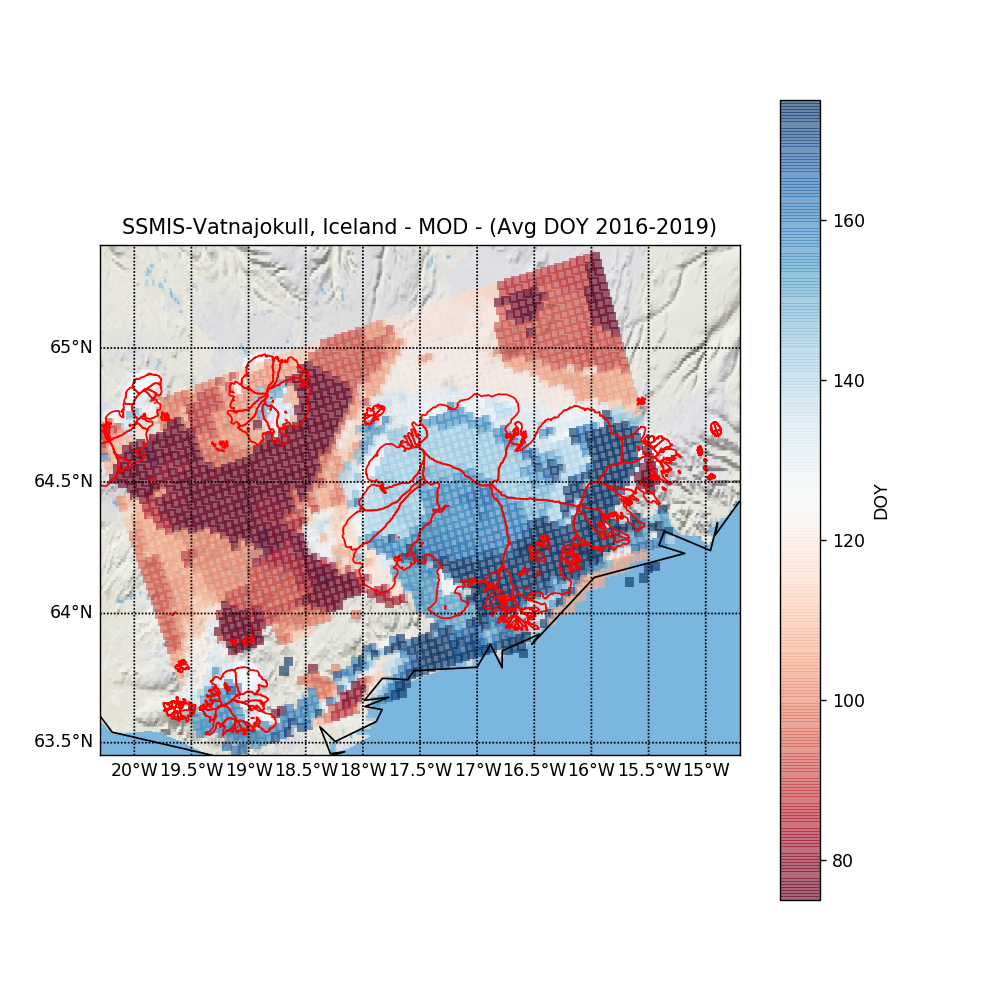

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


<IPython.core.display.Javascript object>


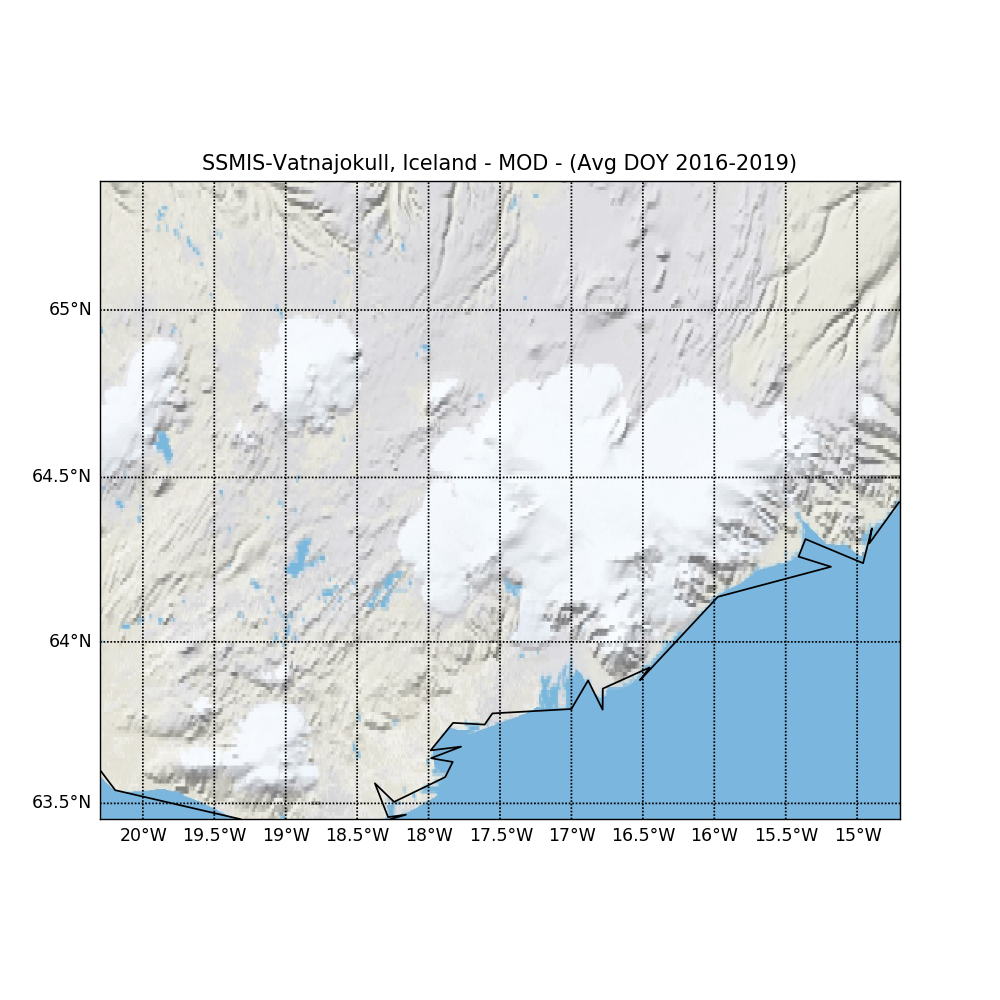

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


In [18]:
# PLOT the MOD MAP - avg of all years or one year of interest - SIR

# Choose plot type - 'year' for one year of interest, 'all' for average of all years
#plot_type='year'  
plot_type='all'

#year=2018


if plot_type=='all':
    array=MOD_DOY_array
    title=sensor_SIR+'-'+Site+' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Iceland', color='red', linewidth=1)

x,y=m(pixel_lons, pixel_lats)
m.scatter(x,y,c=array, s=30, marker='s',lw=0,cmap='RdBu', alpha=.6)
plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)


plt.title(title)
plt.show()


<IPython.core.display.Javascript object>


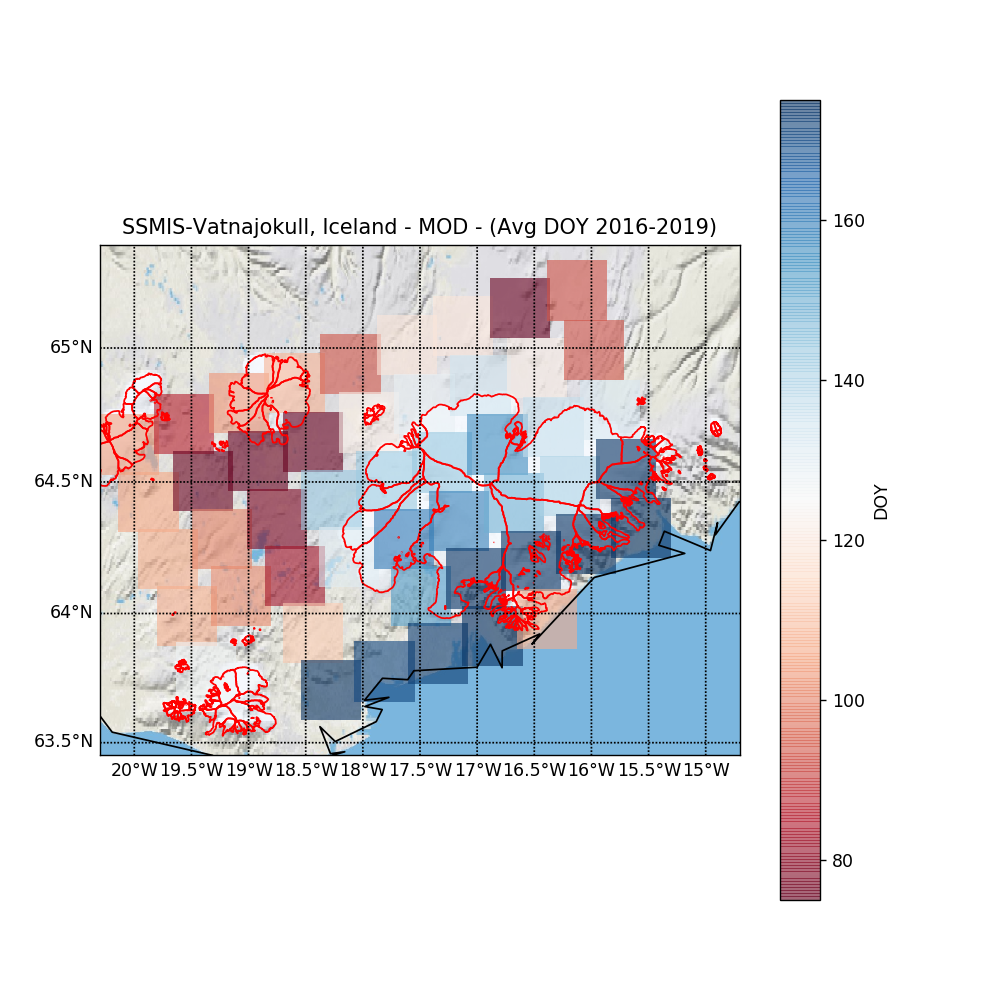

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


<IPython.core.display.Javascript object>


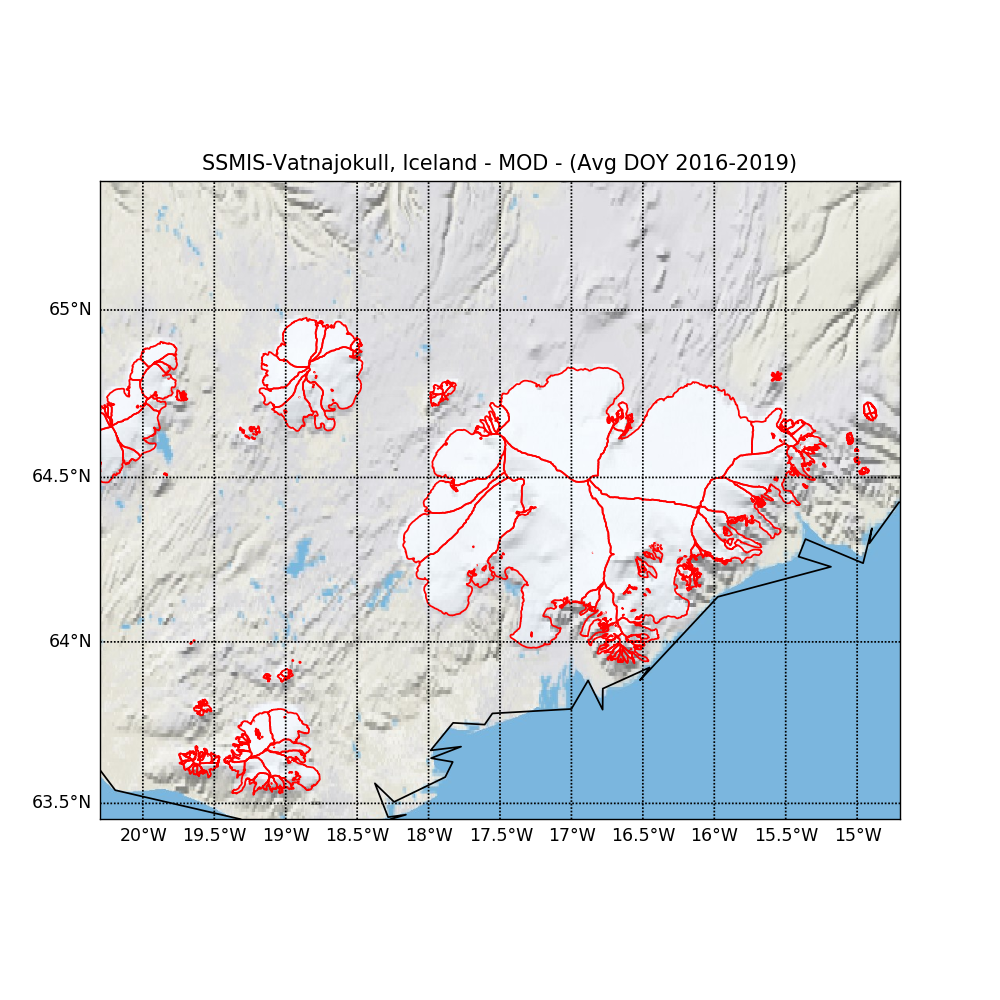

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


In [19]:
# PLOT the MOD MAP - avg of all years or one year of interest - GRD
# Choose plot type - 'year' for one year of interest, 'all' for average of all years
#plot_type='year'  
plot_type='all'

#year=2018


if plot_type=='all':
    array=MOD_DOY_array_GRD
    title=sensor_SIR+'-'+Site+' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_GRD_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y=m(pixel_lons_GRD, pixel_lats_GRD)
m.scatter(x,y,c=array, s=1200, marker='s',lw=0,cmap='RdBu', alpha=.6)

plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)
#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

plt.title(title)
plt.show()